In [5]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [127]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # Simulate and fill sum and count
    for i in range(0, num_episodes):
        observation = env.reset()
        
        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()
            
        # generate episode:
        episode = [] # keep track of states visited
        for t in range(100):
            action = policy(observation)
            next_observation, reward, done, _ = env.step(action)
            # score, dealer_score, usable_ace = observation
            
            # save s_t, A_t, and R_{t+1}
            episode.append((observation, action, reward))
            
            if done:
                # The final state is of no interest, only the final reward.
                break
            
            observation = next_observation
                
        # Book page 92:
        G = 0    
        visited_states = set()
        for (state, action, reward) in reversed(episode):
            # this only works if discount == 1
            G = discount_factor*G + reward
            if state not in visited_states: # first visit only
                returns_sum[state] = returns_sum[state] + G
                returns_count[state] = returns_count[state] + 1
                visited_states.add(state)
                
    # The final value function
    V = defaultdict(float)
    for k in returns_sum:
        score, dealer_score, usable_ace = k
        if (score > 21):
            continue
        V[k] = returns_sum[k]/returns_count[k]
    
    return V    

In [128]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 9000/10000.

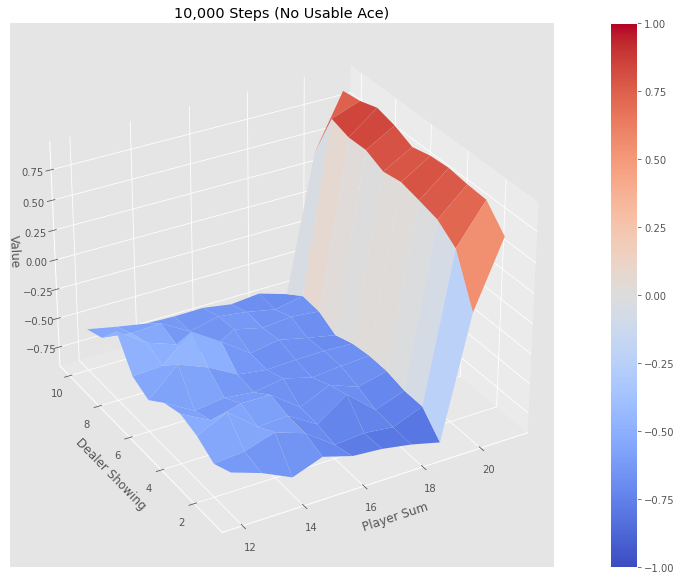

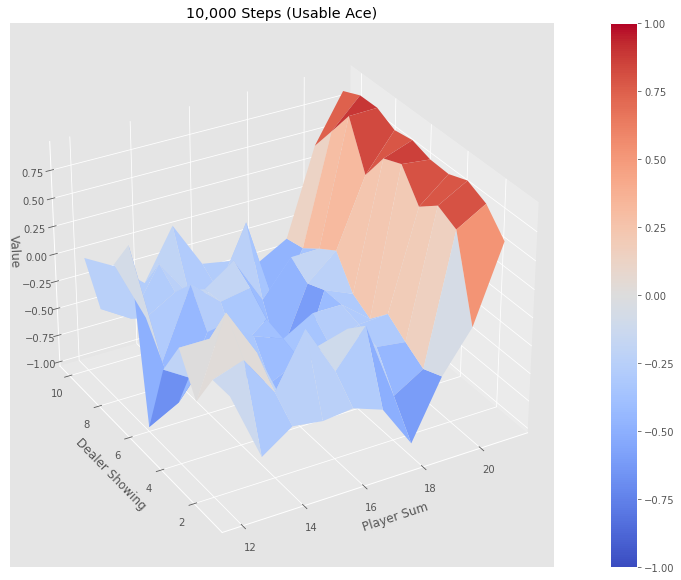

Episode 499000/500000.

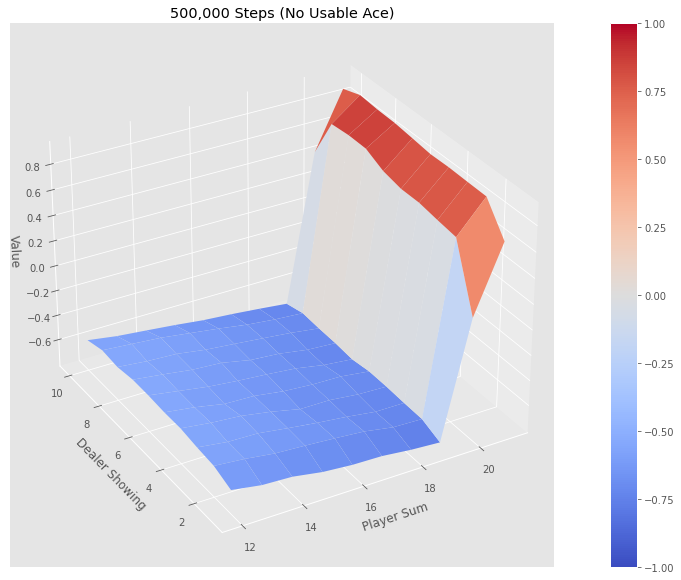

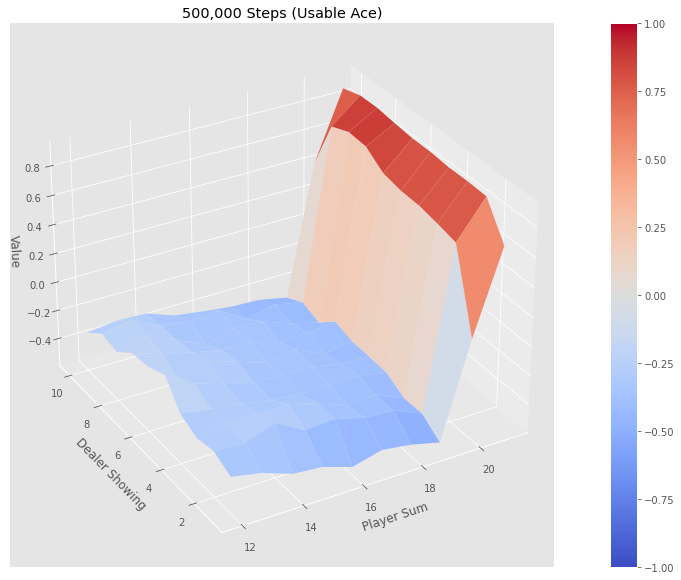

In [129]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")